# Deconvolution of "Purkinje Neuron" with Synthetic PSF

This example will demonstrate deconvolution with a simple but unrealistic point spread function using this confocal [dataset](http://www.cellimagelibrary.org/images/CCDB_2) from the [Cell Image Library](http://www.cellimagelibrary.org/home).
    
**Reference**<br>
Brandner, D. and Withers, G.<br>
The Cell Image Library, CIL: 10106, 10107, and 10108.<br>
Available at http://www.cellimagelibrary.org. Accessed December 08, 2010.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from skimage import exposure
from scipy import ndimage, signal
from flowdec import data as fd_data
from flowdec import psf as fd_psf
from flowdec import restoration as fd_restoration

Load downsampled version of original image stack (from 200x1024x1024 to 50x256x256):

In [2]:
actual = fd_data.neuron_25pct().data
actual.shape

(50, 256, 256)

Create a gaussian kernel that will be used to blur the original acquisition:

In [3]:
kernel = np.zeros_like(actual)
for offset in [0, 1]:
    kernel[tuple((np.array(kernel.shape) - offset) // 2)] = 1
kernel = ndimage.gaussian_filter(kernel, sigma=1.)
kernel.shape

(50, 256, 256)

Convolve the kernel with the original image to get a blurred image from which an attempt to restore the original will be made:

In [4]:
data = signal.fftconvolve(actual, kernel, mode='same')
data.shape

(50, 256, 256)

Run the deconvolution/algorithm (for 30 iterations):

In [5]:
algo = fd_restoration.RichardsonLucyDeconvolver(data.ndim, pad_min=np.ones(data.ndim)).initialize()
res = algo.run(fd_data.Acquisition(data=data, kernel=kernel), niter=2)

In [6]:
res.info

{'data_shape': array([ 50, 256, 256], dtype=int32),
 'kern_shape': array([ 50, 256, 256], dtype=int32),
 'pad_shape': array([ 51, 257, 257], dtype=int32),
 'pad_mode': array('log2', dtype=object),
 'pad_min': array([1, 1, 1], dtype=int32)}

In [11]:
%%time
# Note that deconvolution initialization is best kept separate from execution since the "initialize" 
# operation corresponds to creating a TensorFlow graph, which is a relatively expensive operation and
# should not be repeated across iterations if deconvolving more than one image
algo = fd_restoration.RichardsonLucyDeconvolver(data.ndim).initialize()
res = algo.run(fd_data.Acquisition(data=data, kernel=kernel), niter=30).data

CPU times: user 49.2 s, sys: 1.46 s, total: 50.6 s
Wall time: 43.9 s


Plot max-z projections the original, blurred, and reconstructed images:

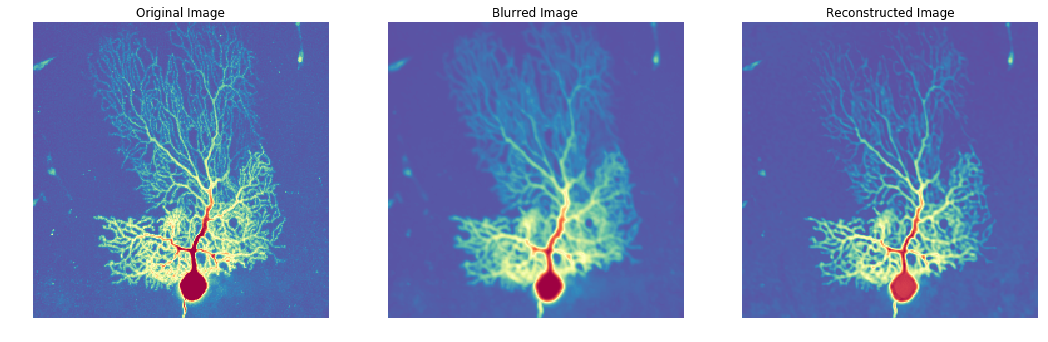

In [164]:
fig, axs = plt.subplots(1, 3)
axs = axs.ravel()
fig.set_size_inches(18, 12)
center = tuple([slice(None), slice(10, -10), slice(10, -10)])
titles = ['Original Image', 'Blurred Image', 'Reconstructed Image']
for i, d in enumerate([actual, data, res]):
    img = exposure.adjust_gamma(d[center].max(axis=0), gamma=.2)
    axs[i].imshow(img, cmap='Spectral_r')
    axs[i].set_title(titles[i])
    axs[i].axis('off')